# E: Corrigiendo la cabecera de un fichero `FITS`

Nos hemos encontrado un fichero `imagenes/fitsHeaderIncorrecto.fit`, generado por [MaxIm DL](https://diffractionlimited.com/product/maxim-dl/) que produce un error al intentar abrirlo con `AstroPy`. El error concretamente es que la cabecera del fichero `BZERO` tiene un valor igual a `0.00000000000000000 0`, cuando debería ser `0.00000000000000000`.

In [1]:
import os
import os.path
import shutil
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

ficheroConflictivo = "imagenes/fitsHeaderIncorrecto.fit"

im = fits.open(ficheroConflictivo)    # Fallará, porque el fichero tiene una cabecera incorrecta:
                                      # BZERO   =  0.00000000000000000 0

    Unparsable card (BZERO), fix it first with .verify('fix').
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]


OSError: Empty or corrupt FITS file

Vamos a corregir reemplazando dicha cabecera de manera artesanal (no podemos usar los mecanismos habituales de `AstroPy` porque la misma biblioteca no es capaz de cargar dicho fichero.

Primero copiamos el fichero para evitar el riesgo de estropear el fichero:

In [2]:
ficheroCorregido = "salidas/fitsHeaderIncorrecto_corregido.fit"

shutil.copyfile(ficheroConflictivo, ficheroCorregido)

'salidas/fitsHeaderIncorrecto_corregido.fit'

In [3]:
def corrigeHeaderFits(nombreArchivo):
    f = open(nombreArchivo, "r+b")          # Abrimos el fichero como lectura y escritura binaria

    readed = b""
    while not readed.startswith(b"END"):    # La última línea de la cabecera debe empezar por END
        readed = f.read(80)                 # Las cabeceras FITS son de 80 caracteres ASCII (80 bytes)
        
        print(readed)

        if readed.startswith(b"BZERO"):             # Si la línea de la cabecera comienza por BZERO
            if b"0.00000000000000000 0" in readed:  # Y encontramos la cadena errónea dentro 
                print("Hemos encontrado un BZERO incorrecto. Sustituyendo")
                f.seek(-80, os.SEEK_CUR)                 # Retrocedemos 80 caracteres el puntero de lectura del fichero
                                                         # Y escribimos la cabecera bien
                f.write(b'BZERO   =  0.00000000000000000                                                  ')  # Ojo! no quitar ni un espacio en blanco de la cadena

    f.close()

corrigeHeaderFits(ficheroCorregido)

b'SIMPLE  =                    T / conforms to FITS standard                      '
b'BITPIX  =                  -32 / array data type                                '
b'NAXIS   =                    2 / number of array dimensions                     '
b'NAXIS1  =                  200                                                  '
b'NAXIS2  =                  200                                                  '
b'BZERO   =  0.00000000000000000 0                                                '
Hemos encontrado un BZERO incorrecto. Sustituyendo
b'DATAMIN =             0.000000                                                  '
b'DATAMAX =           65535.000000                                                '
b"INSTRUME=           'ATIK-460ex: fw rev 3.34'                                   "
b"TELESCOP=           'Mewlon210'                                                 "
b"OBSERVER=           'Pedro Benedicto'                                           "
b"FILTER  = 'Position 0'o

Ahora si podemos cargar y visualizar el fichero corregido:

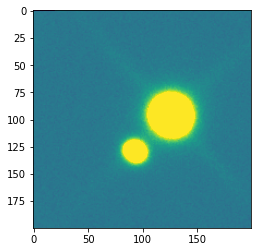

In [4]:
im = fits.open(ficheroCorregido)
data = im[0].data

plt.imshow(data, vmin=np.min(data), vmax=np.max(data)/128)

plt.show()